# 1D MT fixed-layer inversion

## Learning goals

- Understand the concept of Tikhonov curve - impact of the trade-off parameter `beta`
- Understand the concept of overfitting and underfitting
- Understand of the concept of depth-of-investigation (DOI)

In [49]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14

## Generate synthetic MT data

In [50]:
def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs

In [51]:
layer_tops = np.r_[0., -600., -1991., -5786., -9786.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[250., 25, 100., 10., 25.][::-1]
frequencies = np.logspace(0, 3, 31)
# frequencies = np.logspace(-3, 3, 31)
relative_error_rho = 0.05
floor_phase = 2.
dobs = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

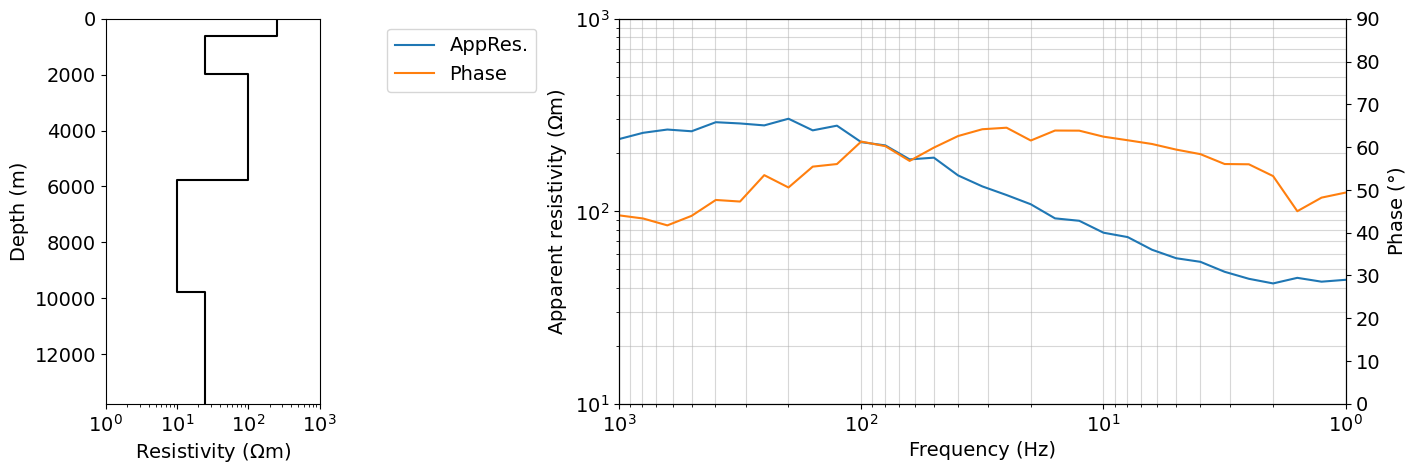

In [52]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1000)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency (Hz)")    
ax.set_ylim(10, 1000)
ax_1.set_ylim(0, 90)    
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(-0.1, 1))
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()

## Run MT inversion

In [53]:
dz = 100
n_layer = 21
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

In [54]:
layer_thicknesses_inv.sum()

18668.799962237365

In [55]:
def run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
    
):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.survey.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(
        mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, mref=mref,
        mapping=maps.IdentityMap(mesh=mesh_inv)
    )

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_schedule,
        target_misfit,
        save_dictionary
    ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

In [56]:
rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()

rho_0 = 100
rho_ref = 100.

output_dict ={}
recovered_model, output_dict = run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=20,
    maxIterCG=30,
    alpha_s=1,
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1e0
)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.72e-01  3.90e+03  0.00e+00  3.90e+03    2.79e+03      0              
   1  3.36e-01  3.57e+02  7.56e+02  6.11e+02    4.30e+02      0              
   2  1.68e-01  9.67e+01  8.69e+02  2.43e+02    2.24e+02      0              
   3  8.39e-02  4.23e+01  9.97e+02  1.26e+02    4.98e+01      0   Skip BFGS  
   4  4.20e-02  3.34e+01  1.06e+03  7.81e+01    3.17e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.8968e+02
1 : |xc-x_last| = 2.4818e-01 <= tolX*(1+|x0|) = 2.2104e+00
0 : |proj(x-g)-x

In [57]:
target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [58]:
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [59]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=5, description='iteration', max=5, min=1), RadioButtons(description='sca…

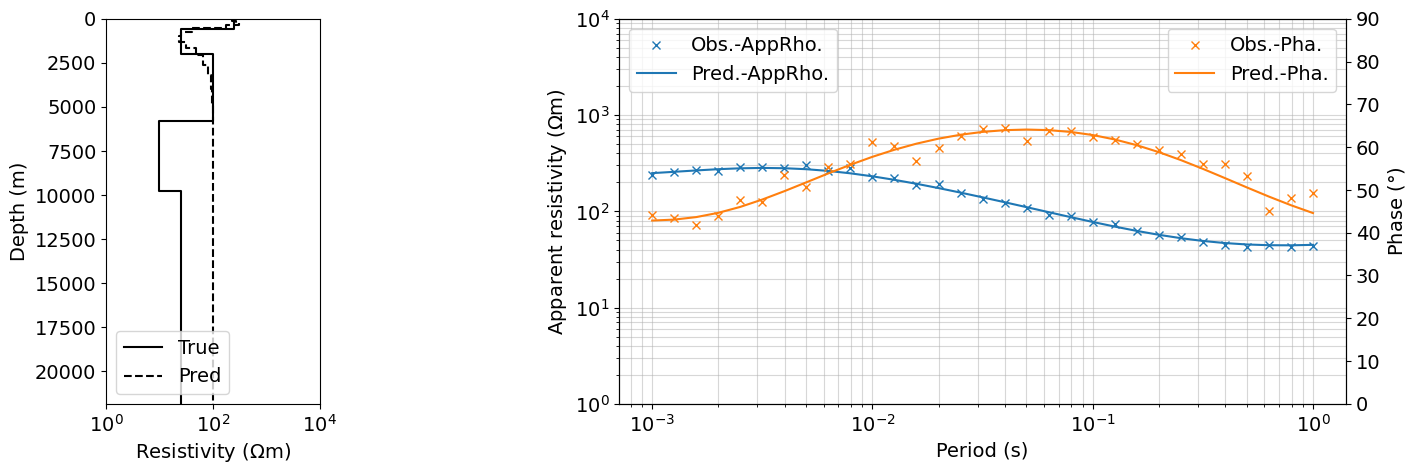

In [60]:
iteration = Q_iter.widget.kwargs['iteration']
dpred = output_dict[iteration]['dpred']
m = output_dict[iteration]['m']
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(np.exp(m)))[::-1],
    ax=ax0,
    color="k",**{'label':'Pred', 'linestyle':'--'}
)
ax0.legend()
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-AppRho.')
ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-AppRho.')

ax_1 = ax.twinx()
ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Period (s)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend(loc=2)
ax_1.legend(loc=1)
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
plt.show()

## Estimate depth-of-investigation

$$ \text{DOI index} = \frac{m_1-m_2}{m_{ref 1}-m_{ref 2}} $$


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.41e+00  3.90e+03  4.51e+03  3.28e+04    2.61e+04      0              
   1  3.20e+00  7.74e+02  2.11e+02  1.45e+03    5.48e+02      0              
   2  1.60e+00  6.67e+02  2.25e+02  1.03e+03    4.60e+02      0   Skip BFGS  
   3  8.01e-01  3.25e+02  3.63e+02  6.16e+02    2.75e+02      0              
   4  4.00e-01  1.39e+02  5.06e+02  3.41e+02    1.69e+02      0   Skip BFGS  
   5  2.00e-01  6.48e+01  6.24e+02  1.90e+02    9.51e+01      0   Skip BFGS  
   6  1.00e-01  3.88e+01  7.07e+02  1.10e+02    4.97e+01      0   Skip BFGS  
------------------------- STOP! --

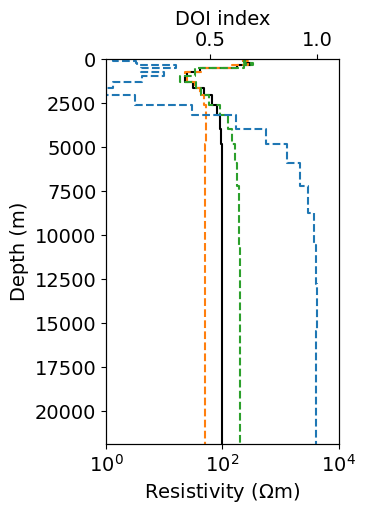

In [62]:
use_doi_index = True
if use_doi_index:
    rho_ref_1 = 50
    m1, _ = run_smooth_inversion(
        dobs,
        standard_deviation,
        rho_0,
        rho_ref_1,
        maxIter=10,
        maxIterCG=30,
        alpha_s=1.,
        alpha_z=1,
        beta0_ratio=1e1,
        coolingFactor=2,
        coolingRate=1,
        chi_factor=1
    )

    rho_ref_2 = 200
    m2, _ = run_smooth_inversion(
        dobs,
        standard_deviation,
        rho_0,
        rho_ref_2,
        maxIter=10,
        maxIterCG=30,
        alpha_s=1.,
        alpha_z=1,
        beta0_ratio=1e1,
        coolingFactor=2,
        coolingRate=1,
        chi_factor=1
    )
    
    def calculate_doi_index(m1, m2, mref1, mref2):
        doi_index = abs((m1-m2) / (mref1-mref2))
        doi_index /= doi_index.max()
        return doi_index

    mref1 = np.exp(1./rho_ref_1)
    mref2 = np.exp(1./rho_ref_2)
    doi_index = calculate_doi_index(m1, m2, mref1, mref2)

    fig, ax = plt.subplots(1,1, figsize=(3, 5))
    plot_1d_layer_model(
        layer_thicknesses_inv[::-1],
        (1./(np.exp(m)))[::-1],
        ax=ax,
        color="k",**{'label':'Pred', 'linestyle':'-'}
    )
    plot_1d_layer_model(
        layer_thicknesses_inv[::-1],
        (1./(np.exp(m1)))[::-1],
        ax=ax,
        color="C1",**{'label':'Pred', 'linestyle':'--'}
    )

    plot_1d_layer_model(
        layer_thicknesses_inv[::-1],
        (1./(np.exp(m2)))[::-1],
        ax=ax,
        color="C2",**{'label':'Pred', 'linestyle':'--'}
    )
    ax.set_xlim(1, 10000)
    ax_1 = ax.twiny()

    plot_1d_layer_model(
        layer_thicknesses_inv[::-1],
        doi_index[::-1],
        ax=ax_1,
        scale='linear',**{'label':'Pred', 'linestyle':'--'}
    )    
    ax.set_xlabel("Resistivity ($\Omega$m)")
    ax_1.set_xlabel("DOI index")